# Reinforcement learning environments

This notebook gathers the functions creating different kinds of environments for foraging and target search in various scenarios, adapted for their use in the reinforcement learning paradigm.

In [ ]:
#| default_exp rl_framework.numba.environments

#| hide
# Libs

In [ ]:
#| export
import numpy as np
import numba
from numba.experimental import jitclass
from numba import float64, bool_, prange, njit
import math
import random

In [ ]:
#| hide
import matplotlib.pyplot as plt

# Helpers

## isBetween

In [ ]:
# |export
@njit
def isBetween_c_Vec_numba(a, b, c, r):
        """
        Checks whether point c is crossing the line formed with point a and b.

        Parameters
        ----------
        a : tensor, shape = (1,2)
            Previous position.
        b : tensor, shape = (1,2)
            Current position.
        c : tensor, shape = (Nt,2)
            Positions of all targets.
        r : int/float
            Target radius.

        Returns
        -------
        mask : array of boolean values
            True at the indices of found targets.

        """
        if (a == b).all():
            return np.array([False]*c.shape[0])

        mask = np.array([True]*c.shape[0])
        
        dotproduct = (c[:, 0] - a[0]) * (b[0] - a[0]) + (c[:, 1] - a[1])*(b[1] - a[1])
        squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
        
        #exclude the targets whose vertical projection of the vector c-a w.r.t. the vector b-a is larger than the target radius.
        idx = np.argwhere(np.abs(numba.np.arraymath.cross2d(b-a, c-a))/np.linalg.norm(b-a) > r) 
        for i1 in idx:
            mask[i1] = False        
        
        #exclude the targets whose scalar product is negative (they are on the other side of the step direction)
        for i2 in np.argwhere(dotproduct < 0):
            mask[i2] = False

        #exclude the targets that are beyond the step.
        for i3 in np.argwhere(dotproduct > squaredlengthba):
            mask[i3] = False
            
        return mask

In [ ]:
compiling = isBetween_c_Vec_numba(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

In [ ]:
%timeit isBetween_c_Vec_numba(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

4.65 μs ± 25.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
from rl_opts.utils import isBetween_c_Vec as oldbetween

In [ ]:
%timeit oldbetween(np.array([0.1,1]), np.array([1,3]), np.random.rand(100,2), 0.00001)

40.4 μs ± 177 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## Pareto sampling

In [ ]:
# |export
@njit
def pareto_sample(alpha, xm, size=1):
    samples = np.zeros(size)
    for ii in range(size):
        u = random.random()  # Uniform random variable between 0 and 1
        x = xm / (u ** (1 / alpha))
        samples[ii] = x
    return samples

## Random sampling from array with probs

In [ ]:
# |export
@njit
def rand_choice_nb(arr, prob):
    """
    :param arr: A 1D numpy array of values to sample from.
    :param prob: A 1D numpy array of probabilities for the given samples.
    :return: A random sample from the given array with a given probability.
    """
    return arr[np.searchsorted(np.cumsum(prob), np.random.random(), side="right")]

# TargetEnv

In [ ]:
#|export
@jitclass([("target_positions", float64[:,:]) ,
           ("current_rewards", float64[:]) ,
           ("kicked", float64[:]) ,
           ("current_directions", float64[:]) ,
           ("positions", float64[:,:]),
           ("previous_pos", float64[:,:]),
           ("lc", float64[:,:]),
           ("mask", bool_[:]),
           ("first_encounter", float64[:,:])])
class TargetEnv():
    Nt : int
    L : float
    r : float
    lc : np.array
    agent_step : float
    num_agents : int
    destructive_targets : bool
    target_positions : np.ndarray
    current_rewards : np.array
    kicked : np.array
    current_directions : np.array
    positions : np.array
    previous_pos : np.array
    mask : np.array
    first_encounter : np.array
    lc_distribution : str
    
    
    def __init__(self,
                 Nt = 10, # Number of targets.
                 L = 1.3, #  Size of the (squared) world.
                 r = 1.5, # Radius with center the target position. It defines the area in which agent detects the target.
                 lc = np.array([[1.0],[1]]), # Cutoff length. Displacement away from target 
                 agent_step = 1, # Displacement of one step. The default is 1.
                 num_agents = 1, # Number of agents that forage at the same time. The default is 1. > 1 not fully implemented
                 destructive = False, # True if targets are destructive. The default is False.
                 lc_distribution = 'constant' # Distribution from where to sample l_c. Can be 'power_law', 'pareto' or something else. See comments self.check_encounter for explanations
                ):
        
        """
        Class defining the a Foraging environment with multiple targets and two actions: continue in 
        the same direction and turn by a random angle.
        """
        
        self.Nt = Nt
        self.L = L
        self.r = r
        self.lc = lc
        self.agent_step = agent_step 
        self.num_agents = num_agents
        self.destructive_targets = destructive
        self.lc_distribution = lc_distribution
        

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L
        
        #store who is/was rewarded
        self.current_rewards = np.zeros(self.num_agents)
        
        #signal whether agent has been kicked
        self.kicked = np.zeros(self.num_agents)
        
        #set positions and directions of the agents
        self.current_directions = np.random.rand(self.num_agents)*2*np.pi
        self.positions = np.random.rand(self.num_agents, 2)*self.L
        self.previous_pos = self.positions.copy()       

        

    def update_pos(self, 
                   change_direction, # Whether the agent decided to turn or not.
                   agent_index = 0 # Index of the given agent. The default is 0. This is only keeped for future devs
                  ):        
        """
        Updates information of the agent depending on its decision.            
        """
        
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        if change_direction:
            self.current_directions[agent_index] = random.uniform(0,1)*2*math.pi
        
        #Update position
        self.positions[agent_index][0] = self.positions[agent_index][0] + self.agent_step*np.cos(self.current_directions[agent_index])
        self.positions[agent_index][1] = self.positions[agent_index][1] + self.agent_step*np.sin(self.current_directions[agent_index])
        
       
    def check_encounter(self,
                       agent_index=0 # Index of the given agent. The default is 0. This is only keeped for future devs
                       ): # True if the agent found a target, else False
        """
        Checks whether the agent found a target, and updates the information accordingly.
        """       
        
        encounters = isBetween_c_Vec_numba(self.previous_pos[agent_index], self.positions[agent_index], self.target_positions, self.r)
        
        if sum(encounters) > 0: 
            
            #if there is more than 1 encounter, pick the closest to the agent.
            if sum(encounters) == 1:
                first_encounter = np.argwhere(encounters == True).flatten()
            else:
                # compute the distance from the previous position to each target            
                distance_previous_pos = np.sqrt((self.previous_pos[agent_index][0]- self.target_positions[:, 0])**2 + (self.previous_pos[agent_index][1] - self.target_positions[:, 1])**2)            
                
                # checking which encountered point is closer to previous position
                min_distance_masked = np.argmin(distance_previous_pos[encounters])
                first_encounter = np.argwhere(encounters == True)[min_distance_masked].flatten()
            if self.destructive_targets:
                self.target_positions[first_encounter] = np.random.rand(2)*self.L
            else:
                #----KICK----
                # If there was encounter, we reset direction and change position of particle to (pos target + lc)
                kick_direction = np.random.uniform(low = 0, high = 2*np.pi)
                for idx_first in first_encounter: # This is super weird!
                    if self.lc_distribution == 'power_law':
                        # when we have the power law, the first value of lc is considered to be the exponent.
                        # The following samples from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0]                        
                        current_lc = (1-random.uniform(0,1))**(-1/self.lc.flatten()[0])

                    elif self.lc_distribution == 'pareto':
                        # Sampling from Pareto. Here alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
                        current_lc = pareto_sample(self.lc[0,0], self.lc[1,0])[0]
                    else:
                        # if lc has a single element, take that one as lc, if not sample
                        current_lc = self.lc.flatten()[0] if len(self.lc.flatten()) == 2 else rand_choice_nb(arr = self.lc[0], prob = self.lc[1])
                    self.positions[agent_index][0] = self.target_positions[idx_first, 0] + current_lc*np.cos(kick_direction)
                    self.positions[agent_index][1] = self.target_positions[idx_first, 1] + current_lc*np.sin(kick_direction)
                self.kicked[agent_index] = 1
                #------------
                
            #...and we add the information that this agent got to the target
            self.current_rewards[agent_index] = 1              
            return 1
        
        else: 
            self.kicked[agent_index] = 0
            self.current_rewards[agent_index] = 0
            return 0   
        
    def check_bc(self):
        """
        Updates position coordinates of agent agent_index to fulfill periodic boundary conditions.

        """
        agent_index=0
        self.positions[agent_index] = (self.positions[agent_index])%self.L
    

In [ ]:
#| hide
env = TargetEnv(Nt = 1000,
                 L = 123,
                 r = 50,
                 lc = np.array([[0.1],[1]]),
                 lc_distribution = 'pareto')
env.check_encounter()

0

#|hide 
#### Runtime testing 

In [ ]:
#|hide 
env = TargetEnv(Nt = 1000,
                 L = 123,
                 r = 50,
                 lc = np.array([[0.1],[1]]),
                 lc_distribution = 'pareto')
compiling = env.check_encounter()

In [ ]:
#|hide 
%timeit env.check_encounter()

2.18 μs ± 13.7 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
#|hide 
#|eval: false

# from rl_opts.rl_framework.numpy import TargetEnv as oldEnv

oenv = oldEnv(Nt = 100,
                 L = 123,
                 r = 0.2,
                 lc = 1)

%timeit oenv.check_encounter()

49.7 μs ± 849 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)

/home/gorka/github/rl_opts/rl_opts/utils.py:36: RuntimeWarning: invalid value encountered in divide
  mask[np.argwhere(np.abs(np.cross(b-a, c-a))/np.linalg.norm(b-a) > r)] = False


## Walk from policy (TargetEnv)

These replicate what we were doing in `rl_opts.learn_and_bench.walk_from_policy` and help get efficiencies for fixed policies.

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def single_agent_walk(N_runs : int, # Total number of runs / episodes to evaluate
                      time_ep : int, # Length of each run / episode
                      policy : np.array, # Policy of the walker
                      env : object# Environment where the walker moves
                     )-> np.array :  # Array containing the number of targets from in each run

    """
    Walk of a single in env of type TargetEnv given a policy. Performance is evaluated as the number of targets found in a fixed time time_ep.
    """
    
    save_rewards = np.zeros(N_runs)
    
    for ep in range(N_runs):
        #initialize environment and agent's counter and g matrix
        env.init_env()
        agent_state = 0

        for t in range(time_ep):
            
            if t == 0 or env.kicked[0]:
                # change direction
                action = rand_choice_nb(arr = np.arange(1, agent.num_actions), prob = np.array([1/len(np.arange(1,agent.num_actions))]*len(np.arange(1,agent.num_actions))))
                env.update_pos(action)
                #check boundary conditions
                env.check_bc()
                #reset counter
                agent_state = 0
                #set kicked value to false again
                env.kicked[0] = 0
                
            else: 
                # decide
                action = 0 if policy[0, agent_state] > np.random.rand() else 1
                #update positions
                env.update_pos(action)
                #check if target was found + kick if it is
                reward = env.check_encounter()
                #check boundary conditions
                env.check_bc()
                # update agent_state
                agent_state += 1
                
                save_rewards[ep] += reward
                
    return save_rewards

In [ ]:
#| export
@njit(parallel = True)
def multi_agents_walk(N_runs : int, # Total number of runs / episodes to evaluate
                      time_ep : int, # Length of each run / episode
                      N_agents : int, # Number of agents to consider
                      Nt = 100, # Number of targets in the environment
                      L = 100, # Size of the environment
                      r = 0.5, # Radius of the targets
                      lc = 1.0, # Parameters of lc distribution or lc itself 
                      agent_step = 1, # Length of agent's step
                      destructive_targets = False, # True if targets are destructive. The default is False. 
                      lc_distribution = 'constant', # lc distribution
                      policy = [[1,1], [0,0]] # Policy of the agents
              )-> np.array : # Array containing number of targets found for each agent at each run.
    """
    Runs in parallel single_agent_walk. Due to numba props, we need to give all parameters as inputs (see source).
    """
    
    save_rewards = np.zeros((N_agents, N_runs))
    
    for n_agent in prange(N_agents):
        
        env = TargetEnv(Nt,L,r,lc,agent_step,1,destructive_targets,lc_distribution)
        
        rews = single_agent_walk(N_runs, time_ep, policy, env) 
    
        save_rewards[n_agent] = rews
        
    return save_rewards

# ResetEnv

### Search loop with fixed policy an arbitrary environment

In [ ]:
#|export

@njit
def reset_search_loop(T, # Number of steps 
                      reset_policy, # Reset policy
                      env # Environment
                      ):
    '''
    Loop that runs the reset environment with a given reset policy.
    '''
    
    rewards = 0
    tau = 0 # time since last reset
    
    for t in range(T):
        
        action = 0 if np.random.rand() > reset_policy[tau] else 1
        rew = env.update_pos(action = action)
        
        if rew == 1 or action == 1:
            tau = 0
        else:
            tau += 1
        
        rewards += rew
    
    return rewards


## 1D

In [ ]:
#|export
@jitclass
class ResetEnv_1D():
    L : float
    D : float    
    position : float    
    
    def __init__(self,
                 L = 1.3,
                 D = 1.0,                    
                ):        
   
        self.L = L
        self.D = D
        self.position = 0
        
    def init_env(self):
        self.position = 0
    
    def update_pos(self, 
                   action # 0: continue walk, 1: reset to origin
                  ): # Reward = 1 if crossed L, else = 0
        
        if action == 0:
            self.position += np.random.randn()*np.sqrt(2*self.D)        
        else: self.position = 0
                
        if self.position >= self.L: 
            self.init_env()
            return 1
        else: return 0

### Parallel search loops for Reset 1D

In [ ]:
#| export
@njit(parallel = True)
def parallel_Reset1D_sharp(T, resets, L, D):
    '''
    Runs the Reset 1D loop in parallel for different sharp resetting times.
    '''
    rews_reset = np.zeros_like(resets)
    
    for idxr in prange(len(resets)):
        
        env = ResetEnv_1D(L, D)        
        reset_policy = np.zeros(resets[idxr])
        reset_policy[resets[idxr]-1] = 1        
        
        rews_reset[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_reset

@njit(parallel = True)
def parallel_Reset1D_exp(T, rates, L, D):
    '''
    Runs the Reset 1D loop in parallel for different exponential resetting rates.
    '''
    
    rews_rate = np.zeros_like(rates)
    for idxr in prange(len(rates)):
        
        env = ResetEnv_1D(L, D)        
        reset_policy = np.ones(T)*rates[idxr]
        
        rews_rate[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_rate

In [ ]:
#| hide
%timeit parallel_Reset1D_sharp(100, np.linspace(70, 150, 20).astype(np.int64), 5, 1)

37.4 μs ± 2.34 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
#| hide
%timeit parallel_Reset1D_exp(100, np.linspace(70, 150, 40).astype(np.int64), 5, 1)

48.2 μs ± 29 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## 2D

In [ ]:
#|export
@jitclass([("position", float64[:]),
           ("target_position", float64[:,:]),
           ("previous_pos", float64[:])
          ])
class ResetEnv_2D():
    D : float    
    dist_target :float
    r: float
    position : np.array    
    target_position : np.array
    previous_pos : np.array
    
    def __init__(self,
                 dist_target = 0.2, # Distance from init position and target
                 radius_target = 0.5, # Radius of the target
                 D = 1.0, # Diffusion coefficient of the walker              
                ):    
        

        self.D = D
        self.dist_target = dist_target
        self.r = radius_target        
        
        self.target_position = np.array([self.dist_target*np.cos(np.pi/4), self.dist_target*np.sin(np.pi/4)])[np.newaxis, :]       
        
        self.init_env()
        
    def init_env(self):
        self.position = np.array([0.0,0.0])
        self.previous_pos = self.position.copy()     
        
        
    
    def update_pos(self, 
                   action # 0: continue walk, 1: reset to origin
                  ): # Reward = 1 if encountered target, else = 0
        
        if action == 1:
            self.init_env()
            return 0
        
        elif action == 0:
            
            self.previous_pos = self.position.copy()            
            self.position += np.random.randn(2)*np.sqrt(2*self.D)
            
            # Checking encounter
            inside_target = np.linalg.norm(self.position-self.target_position) <= self.r
            crossed_target = isBetween_c_Vec_numba(self.previous_pos, self.position, self.target_position, self.r)
                        
            if inside_target or crossed_target:
                self.init_env()
                return 1
            else: 
                return 0
            
        

## Parallel search loops for Reset 2D

In [ ]:
#|export
@njit(parallel = True)
def parallel_Reset2D_sharp(T, resets, dist_target, radius_target, D):
    rews_reset = np.zeros_like(resets)
    
    for idxr in prange(len(resets)): 
        
        env = ResetEnv_2D(dist_target, radius_target, D)        
        reset_policy = np.zeros(resets[idxr])
        reset_policy[resets[idxr]-1] = 1        
        
        rews_reset[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_reset



@njit(parallel = True)
def parallel_Reset2D_exp(T, rates, dist_target, radius_target, D):
    
    rews_rate = np.zeros_like(rates)
    for idxr in prange(len(rates)):
        
        env = ResetEnv_2D(dist_target, radius_target, D)         
        reset_policy = np.ones(T)*rates[idxr]
        
        rews_rate[idxr] = reset_search_loop(T = T, reset_policy = reset_policy, env = env)
    return rews_rate

@njit(parallel = True)
def parallel_Reset2D_policies(T, reset_policies, dist_target, radius_target, D):
    
    rews_rate = np.zeros(reset_policies.shape[0])    
    
    for idx_policy in prange(reset_policies.shape[0]):    
        
        env = ResetEnv_2D(dist_target, radius_target, D)  
                
        rews_rate[idx_policy] = reset_search_loop(T = T, reset_policy = reset_policies[idx_policy], env = env)
        
    return rews_rate

# TurnResetEnv

> Only 2D is considered

In [ ]:
#|export
@jitclass([("position", float64[:]),
           ("target_position", float64[:,:]),
           ("previous_pos", float64[:])
          ])
class TurnResetEnv_2D():
    agent_step : float    
    dist_target :float
    r: float
    position : np.array    
    target_position : np.array
    previous_pos : np.array
    current_direction : float
    
    def __init__(self,
                 dist_target = 0.2, # Distance from init position and target
                 radius_target = 0.5, # Radius of the target
                 agent_step = 1.0, # Diffusion coefficient of the walker              
                ):   
        
        '''
        Class defining a Foraging environment with a single target and three possible actions:

        - Continue in the same direction
        - Turn by a random angle
        - Reset to the origin

        The agent makes steps of constant length given by agent_step. 
        '''
        

        self.agent_step = agent_step
        self.dist_target = dist_target
        self.r = radius_target        
        
        self.target_position = np.array([self.dist_target*np.cos(np.pi/4), self.dist_target*np.sin(np.pi/4)])[np.newaxis, :]       
        
        self.init_env()
        
    def init_env(self):
        self.position = np.array([0.0,0.0])
        self.current_direction = np.random.rand()*2*np.pi
        self.previous_pos = self.position.copy()     
        
        
    
    def update_pos(self, 
                   change_direction, # If True, the agent changes direction by a random angle
                   reset # If True, the agent is reset to the origin
                   ):        
        """
        Updates position of the agent depending on its decision
        """
        
        if reset:
            self.init_env()
            return 0

        else:
            if change_direction:
                self.current_direction = np.random.rand()*2*np.pi

            self.position[0] += self.agent_step*np.cos(self.current_direction)
            self.position[1] += self.agent_step*np.sin(self.current_direction)

            # Checking encounter
            inside_target = np.linalg.norm(self.position-self.target_position) <= self.r
            crossed_target = isBetween_c_Vec_numba(self.previous_pos, self.position, self.target_position, self.r)
                        
            if inside_target or crossed_target:
                self.init_env()
                return 1
            else:                
                self.previous_pos = self.position.copy()
                return 0

## Search loop with fixed policy

In [ ]:
#| export

def search_loop_turn_reset_sharp(T, reset, turn, env):
    """
    Runs a search loop of T steps. There is a single counter that works as follows:

    - Starts at 0
    - For each turn or continue action gets +1
    - If reset or reach the target is set to 0

    """
    
    rewards = 0
    counter = 0 

    env.init_env()
    
    for t in range(T):        
        counter += 1
        # Reset
        if counter == reset:
            rew = env.update_pos(False, # change direction
                                 True   # reset
                                )           
            counter = 0
        
        # Turn
        elif counter == turn:
            rew = env.update_pos(True, # change direction
                                 False # reset
                                )
            
            
        else:
            rew = env.update_pos(False, # change direction
                                 False # reset
                                )
        if rew == 1:
            counter = 0
            
        rewards += rew
        
    return rewards

# TargetDirectedMotion

Differences with respect to the previous environment TargetEnv:

- Actions: continue, rotate left, rotate right, rotate back. The 'left', 'right' and 'back' areas are areas of 120º ($2 \pi/3$) each on the left, right and back of the agent, respectively. After picking an action that is not 'continue', the agent rotates in a random direction within the chosen area.

In [ ]:
#|export
@jitclass([("target_positions", float64[:,:]) ,
           ("current_rewards", float64[:]) ,
           ("kicked", float64[:]) ,
           ("current_directions", float64[:]) ,
           ("positions", float64[:,:]),
           ("previous_pos", float64[:,:]),
           ("lc", float64[:,:]),
           ("mask", bool_[:]),
           ("first_encounter", float64[:,:])])
class TargetDirectedMotion():
    Nt : int
    L : float
    r : float
    lc : np.array
    agent_step : float
    num_agents : int
    destructive_targets : bool
    target_positions : np.ndarray
    current_rewards : np.array
    kicked : np.array
    current_directions : np.array
    positions : np.array
    previous_pos : np.array
    mask : np.array
    first_encounter : np.array
    lc_distribution : str
    
    
    def __init__(self,
                 Nt = 10, # blabla
                 L = 1.3,
                 r = 1.5,
                 lc = np.array([[1.0],[1]]),
                 agent_step = 1,
                 num_agents = 1,
                 destructive = False,
                 lc_distribution = 'constant'):
        
        """        
        Class defining the foraging environment. It includes the methods needed to place several agents to the world.
        
        Updated from `rl_framework.TargetEnv`:        
            > `lc_distribution`: now allows to consider different distributions. lc now means different things depending on the distribution.
        
        **Inputs**
        
        `Nt` : (int) 
            Number of targets.
            
        `L` : (int)
            Size of the (squared) world.
            
        `r` : (int) 
            Radius with center the target position. It defines the area in which agent detects the target.
            
        `lc` 
            Cutoff length. Displacement away from target (to implement revisitable targets by displacing agent away from the visited target).
            
        `agent_step`: (int, optional)
            Displacement of one step. The default is 1.
            
        `num_agents`: (int, optional)
            Number of agents that forage at the same time. The default is 1.
            
        `destructive`: (bool, optional)
            True if targets are destructive. The default is False.
            
        `lc_distribution`: (str) Chosee between 'power_law', 'pareto' and 'constant'. Depending on the previous choice, lc has different meanings:
        
        > `power_law` : lc is sampled from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0] 
        
        > `pareto` : lc is sampled from a Pareto distribution with alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
        
        > `constant` : if len(lc) == 1, then that's the lc. If len(lc) > 1, then samples an lc considering vals = lc[0] and probabilities = lc[1]
        """
        
        
        self.Nt = Nt
        self.L = L
        self.r = r
        self.lc = lc
        self.agent_step = agent_step 
        self.num_agents = num_agents
        self.destructive_targets = destructive
        self.lc_distribution = lc_distribution
        

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L
        
        #store who is/was rewarded
        self.current_rewards = np.zeros(self.num_agents)
        
        #signal whether agent has been kicked
        self.kicked = np.zeros(self.num_agents)
        
        #set positions and directions of the agents
        self.current_directions = np.random.rand(self.num_agents)*2*np.pi
        self.positions = np.random.rand(self.num_agents, 2)*self.L
        self.previous_pos = self.positions.copy()       

        

    def update_pos(self, action, agent_index = 0):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        action : int
            0 (continue), 1 (left), 2 (right), 3 (back).
        agent_index : int, optional
            Index of the given agent. The default is 0.
        """
        
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        if action == 0: #if agent continues, it does not change its direction.
            pass
        elif action == 1: #left
            self.current_directions[agent_index] += random.uniform(0,1)*2*np.pi/3
        elif action == 2: #right
            self.current_directions[agent_index] -= random.uniform(0,1)*2*np.pi/3
        elif action == 3: #back
            self.current_directions[agent_index] += 2*np.pi/3 + random.uniform(0,1)*2*np.pi/3
        else:
            print('This action value is not defined')
            
        #Update position
        self.positions[agent_index][0] = self.positions[agent_index][0] + self.agent_step*np.cos(self.current_directions[agent_index])
        self.positions[agent_index][1] = self.positions[agent_index][1] + self.agent_step*np.sin(self.current_directions[agent_index])
        
       
    def check_encounter(self):
        """
        Checks whether the agent found a target, and updates the information accordingly.

        Parameters
        ----------
        agent_index : int, optional

        Returns
        -------
        True if the agent found a target.

        """       
        agent_index = 0
        encounters = isBetween_c_Vec_numba(self.previous_pos[agent_index], self.positions[agent_index], self.target_positions, self.r)
        
        if sum(encounters) > 0: 
            
            #if there is more than 1 encounter, pick the closest to the agent.
            if sum(encounters) == 1:
                first_encounter = np.argwhere(encounters == True).flatten()
            else:
                # compute the distance from the previous position to each target            
                distance_previous_pos = np.sqrt((self.previous_pos[agent_index][0]- self.target_positions[:, 0])**2 + (self.previous_pos[agent_index][1] - self.target_positions[:, 1])**2)            
                
                # checking which encountered point is closer to previous position
                min_distance_masked = np.argmin(distance_previous_pos[encounters])
                first_encounter = np.argwhere(encounters == True)[min_distance_masked].flatten()
            if self.destructive_targets:
                self.target_positions[first_encounter] = np.random.rand(2)*self.L
            else:
                #----KICK----
                # If there was encounter, we reset direction and change position of particle to (pos target + lc)
                kick_direction = np.random.uniform(low = 0, high = 2*np.pi)
                for idx_first in first_encounter: # This is super weird!
                    if self.lc_distribution == 'power_law':
                        # when we have the power law, the first value of lc is considered to be the exponent.
                        # The following samples from a power law x^{-1-alpha} where alpha = self.lc.flatten()[0]                        
                        current_lc = (1-random.uniform(0,1))**(-1/self.lc.flatten()[0])

                    elif self.lc_distribution == 'pareto':
                        # Sampling from Pareto. Here alpha = self.lc.flatten()[0] and x_minim = self.lc.flatten()[0]
                        current_lc = pareto_sample(self.lc[0,0], self.lc[1,0])[0]
                    else:
                        # if lc has a single element, take that one as lc, if not sample
                        current_lc = self.lc.flatten()[0] if len(self.lc.flatten()) == 2 else rand_choice_nb(arr = self.lc[0], prob = self.lc[1])
                    self.positions[agent_index][0] = self.target_positions[idx_first, 0] + current_lc*np.cos(kick_direction)
                    self.positions[agent_index][1] = self.target_positions[idx_first, 1] + current_lc*np.sin(kick_direction)
                self.kicked[agent_index] = 1
                #------------
                
            #...and we add the information that this agent got to the target
            self.current_rewards[agent_index] = 1              
            return 1
        
        else: 
            self.kicked[agent_index] = 0
            self.current_rewards[agent_index] = 0
            return 0   
        
    def check_bc(self):
        """
        Updates position coordinates of agent agent_index to fulfill periodic boundary conditions.

        """
        agent_index=0
        self.positions[agent_index] = (self.positions[agent_index])%self.L
    

## Walk from policy (TargetDirectedMotion)

The following function is the same as `single_agent_walk` with the following differences:
- One environment (same target positions all the time)
- It saves the trajectories and the target positions
- The policy is the one with 4 actions (continue, left, right, back)

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def single_agent_trajectory(time_ep : int, # Length of each run / episode
                            policy : np.array, # Policy of the walker (rows: states. columns:prob of doing each action)
                            env : object # Environment where the walker moves
                           )-> tuple: # number of visited targets, agent and target positions

    '''
    Walk of a single agent in env of type TargetDirectedMotion given a policy. Performance is evaluated as the number of targets found in a fixed time time_ep.
    '''
    
    number_visited_targets = 0
    agent_positions = np.zeros((time_ep, 2))
    
    
    #initialize environment and agent's counter and g matrix
    env.init_env()
    agent_state = 0

    for t in range(time_ep):
        
        agent_positions[t,:] = env.positions[0] #position of agent with index 0

        if t == 0 or env.kicked[0]:
            # change direction
            action = rand_choice_nb(arr = np.arange(1, len(policy[0])), prob = np.array([1/len(np.arange(1,len(policy[0])))]*len(np.arange(1,len(policy[0])))))
            env.update_pos(action)
            #check boundary conditions
            env.check_bc()
            #reset counter
            agent_state = 0
            #set kicked value to false again
            env.kicked[0] = 0

        else: 
            # decide       
            action = rand_choice_nb(arr = np.arange(len(policy[0])), prob = policy[agent_state])
            #update positions
            env.update_pos(action)
            #check if target was found + kick if it is
            reward = env.check_encounter()
            #check boundary conditions
            env.check_bc()
            # update agent_state
            if action == 0:
                agent_state += 1
            else:
                agent_state = 0

            number_visited_targets += reward
                
    return (number_visited_targets, agent_positions, env.target_positions) 

In [ ]:
#| export
@njit(parallel = True)
def parallel_agents_trajectories(time_ep : int, # Length of each run / episode
                                 N_agents : int, # Number of agents to consider
                                 Nt = 100, # Number of targets in the environment
                                 L = 100, # Size of the environment
                                 r = 0.5, # Radius of the targets
                                 lc = np.array([[1.0],[1]]), # Parameters of lc distribution or lc itself 
                                 agent_step = 1, # Length of agent's step
                                 destructive_targets = False, # True if targets are destructive. The default is False. 
                                 lc_distribution = 'constant', # lc distribution
                                 policies = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0]]) # Policy of the agents
                                )-> tuple: # number of visited targets, agent and target positions
    """
    Runs in parallel single_agent_trajectory. Due to numba props, we need to give all parameters as inputs (see source).
    """
    
    agent_positions = np.zeros((N_agents, time_ep, 2))
    number_visited_targets = np.zeros(N_agents)
    target_positions = np.zeros((N_agents, Nt, 2))
    
    for n_agent in prange(N_agents):
        
        env = TargetDirectedMotion(Nt,L,r,lc,agent_step,1,destructive_targets,lc_distribution)
        
        num_tar, pos, tar_pos = single_agent_trajectory(time_ep, policies[n_agent], env) 
    
        agent_positions[n_agent] = pos
        number_visited_targets[n_agent] = num_tar
        target_positions[n_agent] = tar_pos
        
    return (number_visited_targets, agent_positions, target_positions)

# CollectiveSearch

Environment where several agents search for targets. Each agent can see neighbours within a certain visual radius. 

- Actions: continue, rotate left, rotate right, rotate back. The 'left', 'right' and 'back' areas are areas of 120º ($2 \pi/3$) each on the left, right and back of the agent, respectively. After picking an action that is not 'continue', the agent rotates in a random direction within the chosen area.

- States: the agent perceives the counter of steps walking straight and (TO DO) states related to the neighbours.

- Instead of kick, here we implement a time delay $\tau_i$ for each agent $i$. The agent needs to wait $\tau_i$ time steps from the moment it gets a target until it can get the same target again. The equivalence between kick and time delay is $\tau_i = lc + 2$.

- When the agent crosses a target, it resets the counter of steps walking straight and its position is updated to the center of the found target.

In [ ]:
#|export
@jitclass([("target_positions", float64[:,:]) ,
           ("current_rewards", float64[:]) ,
           ("tau_allagents", float64[:]) ,
           ("depleted", float64[:,:]) ,
           ("current_directions", float64[:]) ,
           ("positions", float64[:,:]),
           ("previous_pos", float64[:,:]),
           ("mask", bool_[:])])
           
class CollectiveSearch():
    Nt : int
    L : float
    r : float
    agent_step : float
    num_agents : int
    target_positions : np.ndarray
    current_rewards : np.array
    tau_allagents : np.array
    depleted : np.array
    current_directions : np.array
    positions : np.array
    previous_pos : np.array
    mask : np.array
    
    
    def __init__(self,
                 Nt:int, # Number of targets.
                 L:float, # Size of the (squared) world.
                 r:float, # Radius with center the target position. It defines the area in which agent detects the target.
                 tau:float, # Time it takes for the targets to replenish.
                 agent_step:float=1.0, # Displacement of the agent when it performs one step.
                 num_agents:int=1, # Number of agents that forage at the same time.
                 ):
        
        """        
        Class defining the foraging environment with replenishable targets modeled with a time delay instead of a kick. 
        It includes the methods needed to place several agents to the world.
        
        """
        
        
        self.Nt = Nt
        self.L = L
        self.r = r
        self.agent_step = agent_step 
        self.num_agents = num_agents
        
        # same replenishing time for all agents
        self.tau_allagents = tau * np.ones(self.num_agents)
        

        self.init_env()
        
    def init_env(self):
        """
        Environment initialization.
        """
        self.target_positions = np.random.rand(self.Nt, 2)*self.L
        
        #store who is/was rewarded
        self.current_rewards = np.zeros(self.num_agents)
        
        #number of steps since last target encounter, for each agent.
        self.depleted = np.zeros((self.Nt, self.num_agents))
        
        #set positions and directions of the agents
        self.current_directions = np.random.rand(self.num_agents)*2*np.pi
        self.positions = np.random.rand(self.num_agents, 2)*self.L
        self.previous_pos = self.positions.copy()       

        

    def update_pos(self, action, agent_index = 0):        
        """
        Updates information of the agent depending on its decision.

        Parameters
        ----------
        action : int
            0 (continue), 1 (left), 2 (right), 3 (back).
        agent_index : int, optional
            Index of the given agent. The default is 0.
        """
        
        # Save previous position to check if crossing happened
        self.previous_pos[agent_index] = self.positions[agent_index].copy()
        
        if action == 0: #if agent continues, it does not change its direction.
            pass
        elif action == 1: #left
            self.current_directions[agent_index] += random.uniform(0,1)*2*np.pi/3
        elif action == 2: #right
            self.current_directions[agent_index] -= random.uniform(0,1)*2*np.pi/3
        elif action == 3: #back
            self.current_directions[agent_index] += 2*np.pi/3 + random.uniform(0,1)*2*np.pi/3
        else:
            print('This action value is not defined')
            
        #Update position
        self.positions[agent_index][0] = self.positions[agent_index][0] + self.agent_step*np.cos(self.current_directions[agent_index])
        self.positions[agent_index][1] = self.positions[agent_index][1] + self.agent_step*np.sin(self.current_directions[agent_index])
        
       
    def check_encounter(self, agent_index = 0):
        """
        Checks whether the agent found a target, and updates the information accordingly.

        Parameters
        ----------
        agent_index : int, optional

        Returns
        -------
        True if the agent found a target.

        """
        
        # Check if there was a target encounter
        encounters = isBetween_c_Vec_numba(self.previous_pos[agent_index], self.positions[agent_index], self.target_positions, self.r)
        if sum(encounters) > 0: 
            # If there is more than 1 encounter, pick the closest to the agent.
            if sum(encounters) == 1:
                first_encounter = np.argwhere(encounters == True).flatten()
            else:
                # compute the distance from the previous position to each target            
                distance_previous_pos = np.sqrt((self.previous_pos[agent_index][0]- self.target_positions[:, 0])**2 + (self.previous_pos[agent_index][1] - self.target_positions[:, 1])**2)            
                
                # checking which encountered point is closer to previous position
                min_distance_masked = np.argmin(distance_previous_pos[encounters])
                first_encounter = np.argwhere(encounters == True)[min_distance_masked].flatten()
           
            # If the agent is NOT waiting for the recently found target to replenish:
            if not self.depleted[first_encounter, agent_index]:
                # We add the information that this agent got a reward
                self.current_rewards[agent_index] = 1
                # The replenishing time for this target and this agent starts.
                self.depleted[first_encounter, agent_index] += 1
                
                # The agent moves to the target's position.
                self.positions[agent_index] = self.target_positions[first_encounter].copy()
           
                # The env issues a positive reward.
                return 1
            else:
                self.current_rewards[agent_index] = 0
                return 0
                    
        else:
            self.current_rewards[agent_index] = 0
            return 0   
    
    def update_replenishing_times(self, agent_index = 0):
        """
        Updates the replenishing times of the targets for a given agent.
        """
        self.depleted[np.argwhere(self.depleted[:, agent_index] != 0).flatten(), agent_index] += 1
        self.depleted[:, agent_index] = self.depleted[:, agent_index] % (self.tau_allagents[agent_index] + 1)
        
    def check_bc(self, agent_index = 0):
        """
        Updates position coordinates of a given agent to fulfill periodic boundary conditions.

        """
        self.positions[agent_index] = (self.positions[agent_index])%self.L
    

## Walk from policy (CollectiveSearch)

The following function is the same as `single_agent_walk` with the following differences:
- One environment (same target positions all the time)
- It saves the trajectories and the target positions
- The policy is the one with 4 actions (continue, left, right, back)

In [ ]:
#| export                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
@njit
def single_agent_trajectory_tau(time_ep : int, # Length of each run / episode
                            policy : np.array, # Policy of the walker (rows: states. columns:prob of doing each action)
                            env : object # Environment where the walker moves
                           )-> tuple: # number of visited targets, agent and target positions

    '''
    Walk of a single agent in env of type CollectiveSearch given a policy. Performance is evaluated as the number of targets found in a fixed time time_ep.
    '''
    
    number_visited_targets = 0
    agent_positions = np.zeros((time_ep, 2))
    rew_per_timestep = np.zeros(time_ep)
    
    #initialize environment and agent's counter and g matrix
    env.init_env()
    agent_state = 0

    for t in range(time_ep):
        
        agent_positions[t,:] = env.positions[0] #position of agent with index 0
        
        if t == 0 or env.current_rewards[0] == 1:
            # change direction
            action = rand_choice_nb(arr = np.arange(1, len(policy[0])), prob = np.array([1/len(np.arange(1,len(policy[0])))]*len(np.arange(1,len(policy[0])))))
            env.update_pos(action)
            #check boundary conditions
            env.check_bc()
            #reset counter
            agent_state = 0
            #update current rewards
            env.current_rewards[0] = 0
            reward = 0
            #update replenishing times
            env.update_replenishing_times()
            

        else: 
            # decide       
            action = rand_choice_nb(arr = np.arange(len(policy[0])), prob = policy[agent_state])
            #update positions
            env.update_pos(action)
            #update replenishing times
            env.update_replenishing_times()
            
            #check if target was found 
            reward = env.check_encounter()
            
            #check boundary conditions
            env.check_bc()
            
            # update agent_state
            if action == 0: #continue
                agent_state += 1
            else: #turn
                agent_state = 0

            number_visited_targets += reward
            rew_per_timestep[t] += reward
                
    return (number_visited_targets, agent_positions, env.target_positions, rew_per_timestep) 

In [ ]:
env = CollectiveSearch(Nt = 100,
                       L = 100, 
                       r = 1, 
                       tau = 3)

time_ep = 300
#initial policy with 4 actions
policy = (np.array([0.988, 0.012/3, 0.012/3, 0.012/3])*np.ones((4, time_ep)).transpose())
policy[1] = np.array([0.1, 0, 0, 0.9])

num_targets, agent_pos, target_pos, rew_t = single_agent_trajectory_tau(time_ep = time_ep, # Length of each run / episode
                                                                policy = policy, # Policy of the walker (rows: states. columns:prob of doing each action)
                                                                env = env # Environment where the walker moves
                                                                )

(81.0, 84.0, 6.0, 11.0)

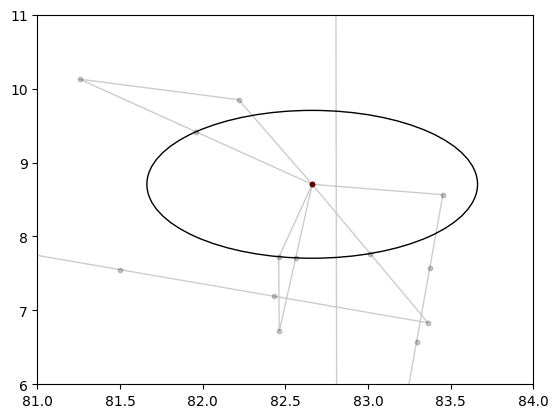

In [ ]:
agent_index = 0
r = 1 #target radius
x_min = 81; x_max = 84 ; y_min = 6 ; y_max = 11;
fig, ax = plt.subplots()
for target in target_pos:
    circle = plt.Circle((target[0], target[1]), r, fill=False)
    ax.add_patch(circle)
#plt.scatter(target_pos[:,0], target_pos[:,1], color = 'g', s=15)
ax.plot(agent_pos[:,0], agent_pos[:,1], color='k', alpha=0.2, linewidth=1)

ax.scatter(agent_pos[:,0],agent_pos[:,1], color='k', alpha=0.2, s=10)

ax.axis([x_min, x_max, y_min, y_max])

In [ ]:
#| export
@njit(parallel = True)
def parallel_agents_trajectories_tau(time_ep : int, # Length of each run / episode
                                 N_agents : int, # Number of agents to consider
                                 Nt = 100, # Number of targets in the environment
                                 L = 100, # Size of the environment
                                 r = 0.5, # Radius of the targets
                                 tau = 3, # Time delay until target is available again
                                 agent_step = 1, # Length of agent's step
                                 policies = np.array([[1.0,0.0,0.0,0.0], [0.0,1.0,0.0,0.0]]) # Policy of the agents
                                )-> tuple: # number of visited targets, agent and target positions
    """
    Runs in parallel single_agent_trajectory_tau. Due to numba props, we need to give all parameters as inputs (see source).
    """
    
    agent_positions = np.zeros((N_agents, time_ep, 2))
    number_visited_targets = np.zeros(N_agents)
    target_positions = np.zeros((N_agents, Nt, 2))
    reward_per_timestep = np.zeros((N_agents, time_ep))
    
    for n_agent in prange(N_agents):
        
        env = CollectiveSearch(Nt,L,r,tau,agent_step,1)
        
        num_tar, pos, tar_pos, rew_t = single_agent_trajectory_tau(time_ep, policies[n_agent], env) 
    
        agent_positions[n_agent] = pos
        number_visited_targets[n_agent] = num_tar
        target_positions[n_agent] = tar_pos
        reward_per_timestep[n_agent] = rew_t
        
    return (number_visited_targets, agent_positions, target_positions, reward_per_timestep)

#| hide
# nbdev

In [ ]:
#| hide
from nbdev import nbdev_export ; nbdev_export()